# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [2]:
import numpy as np
import random as rn
import os
import imageio
from imageio import imread
from skimage.transform import resize
import datetime
import os
import cv2
from tensorflow import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers, regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D,LSTM, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
import time
from keras.models import load_model

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [4]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())


In [5]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

In [6]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
   
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    # Add EarlyStopping callback
    #early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    #return [checkpoint, LR, early_stopping]
    return [checkpoint, LR]

In [7]:
def CropResizeImage(image, height, width):
    # Crop and resize logic
    shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-30,30)], [0, 1, np.random.randint(-30,30)]]),
                            (image.shape[1], image.shape[0]))
    
    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
    x0, y0 = np.argwhere(gray > 0).min(axis=0)
    x1, y1 = np.argwhere(gray > 0).max(axis=0)
    
    cropped = shifted[x0:x1, y0:y1, :]

    image_resized = cv2.resize(cropped, (height, width))

    return(image_resized)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
total_frames = 30
num_classes = 5  #number of softmax classes

datagen = ImageDataGenerator(
                            zoom_range=0.1,
                            zca_whitening=True,
                            width_shift_range=0.1,
                            brightness_range=[0.8, 1.2], 
                            height_shift_range=0.1)

def generator(source_path, folder_list, batch_size, num_images=20, height=120, width=120, augment=False,crop=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx  = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) 
    #create a list of image numbers you want to use for a particular video
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,num_images,width,height,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,num_classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if crop:
                        image = CropResizeImage(image,height, width)
                    else:
                        h, w, c = image.shape
                        image = resize(image, (height, width), anti_aliasing=True)
                    
                     # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)    
                    
                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image     
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output           

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    #NOTE : The Initial models were created with basic image resizing but later realised logic to crop image was missing.
                    #Since few models were build without cropping, we have added crop as parameter so that those model's logs are still intact with the code.
                    if crop:
                        image = CropResizeImage(image,height, width)
                    else:
                        h, w, c = image.shape
                        image = resize(image, (height, width), anti_aliasing=True)                      
                    
                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                     
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [9]:
# Common utility to create conv 3D models
def GestureRecognitionModel(conv_filters=[16, 32, 64, 128],kernel_size=(3, 3, 3), dense_nodes=[256,128], dropout=0.25, num_images=20, height=120, width=120,regularization_strength=0):

    model = Sequential()
    
    # Add Conv3D layers
    for filters in conv_filters:
        model.add(Conv3D(filters, kernel_size, padding='same', input_shape=(num_images, height, width, 3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())

    # Add Dense layers
    for nodes in dense_nodes:
        model.add(Dense(nodes))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        # Add L2 regularization if the regularization_strength parameter is greater than 0
        if regularization_strength > 0:
            model.add(Dense(nodes, kernel_regularizer=regularizers.l2(regularization_strength)))


    # Output layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

In [10]:
def Conv2D_RNN_GestureRecognitionModel(conv_filters=[16, 32, 64, 128], kernel_size=(3, 3), lstm_unit=64,
                                       dense_nodes=[256, 128], dropout=0.25, num_images=20,
                                       height=120, width=120, regularization_strength=0.01,
                                       num_classes=5,pooling=True):

    model = Sequential()

    # Add Conv2D layers with TimeDistributed wrapper
    for filters in conv_filters:
        model.add(TimeDistributed(Conv2D(filters, kernel_size, padding='same', input_shape=(height, width, 3))))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(BatchNormalization()))
        if pooling:
            model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    # Add TimeDistributed Flatten layer to prepare for RNN
    model.add(TimeDistributed(Flatten()))

    # Add RNN layer
    #model.add(LSTM(lstm_unit))  -- USed in Model 11
    
    model.add(LSTM(lstm_unit, dropout=dropout, recurrent_dropout=dropout))
    
    # Add Dense layers
    for nodes in dense_nodes:
        model.add(Dense(nodes))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        # Add L2 regularization if the regularization_strength parameter is greater than 0
        if regularization_strength > 0:
            model.add(Dense(nodes, kernel_regularizer=regularizers.l2(regularization_strength)))

    # Output layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = optimizers.Adam()  # write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    dummy_input = np.random.rand(1, num_images, height, width, 3)  # Generate random dummy input
    model.build(input_shape=(1, num_images, height, width, 3))  # Build the model with the dummy input shape
    
    return model


In [11]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [12]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

# MODEL EXPLORATION

## Type : Conv 3D

### Conv3D : Model 1

In [11]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = GestureRecognitionModel(num_images=num_frames)

print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 30
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                              

2023-08-06 09:57:45.850199: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-08-06 09:57:45.850280: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3f:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [17]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames)

In [18]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 1.1501 - categorical_accuracy: 0.5626Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 6.75066, saving model to model_conv3D_1_2023-08-0408_52_05.573057/model-00001-1.15010-0.56259-6.75066-0.21000.h5
67/67 [==============================] - 163s 2s/step - loss: 1.1501 - categorical_accuracy: 0.5626 - val_loss: 6.7507 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 0.9428 - categorical_accuracy: 0.6365
Epoch 00002: val_loss improved from 6.75066 to 4.16732, saving model to model_conv3D_1_2023-08-0408_52_05.573057/model-00002-0.94281-0.63650-4.16732-0.24000.h5
67/67 [==============================] - 161s 2s/step - loss: 0.9428 - categorical_accuracy: 0.6365 - val_loss: 4.1673 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


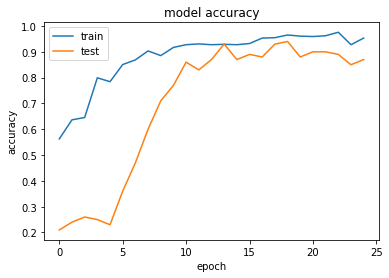

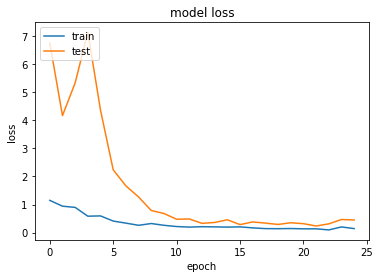

In [21]:
plot_loss_accuracy(history)

### Conv3D : Model 2

In [22]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model2 = GestureRecognitionModel(conv_filters=[8,16, 32, 64],kernel_size=(3,3,3), dense_nodes=[64],dropout=0.1,num_images=20,height=height, width=width)

print (model2.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 30
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 20, 120, 120, 8)   656       
                                                                 
 activation_24 (Activation)  (None, 20, 120, 120, 8)   0         
                                                                 
 batch_normalization_20 (Bat  (None, 20, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 10, 60, 60, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 10, 60, 60, 16)    3472      
                                                            

In [14]:
# Check for GPU devices
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [23]:
callbacks_list = model_callbacks("model_conv3D_2")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames)

history2 = model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.0558 - categorical_accuracy: 0.5973Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 4.27836, saving model to model_conv3D_2_2023-08-0505_05_48.492235/model-00001-1.05575-0.59729-4.27836-0.18000.h5
67/67 [==============================] - 165s 2s/step - loss: 1.0558 - categorical_accuracy: 0.5973 - val_loss: 4.2784 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.6154 - categorical_accuracy: 0.7843
Epoch 00002: val_loss did not improve from 4.27836
67/67 [==============================] - 158s 2s/step - loss: 0.6154 - categorical_accuracy: 0.7843 - val_loss: 5.3406 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.4364 - categorical_accuracy: 0.8492
Epoch 000

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


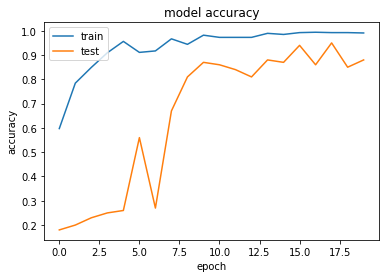

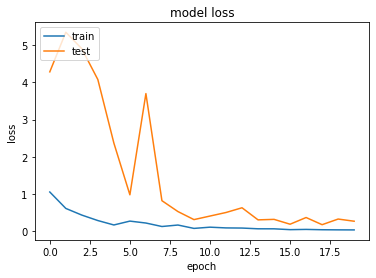

In [26]:

import matplotlib.pyplot as plt
plot_loss_accuracy(history2)

### Conv3D : Model 3

In [27]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 32  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model3 = GestureRecognitionModel(conv_filters=[8,16, 32, 64],kernel_size=(3,3,3), dense_nodes=[64],dropout=0.1,num_images=num_frames,height=height, width=width)

print (model3.summary())

# epochs = 20
# batch size = 32
# num_frames per video = 20
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 20, 120, 120, 8)   656       
                                                                 
 activation_30 (Activation)  (None, 20, 120, 120, 8)   0         
                                                                 
 batch_normalization_25 (Bat  (None, 20, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 10, 60, 60, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 10, 60, 60, 16)    3472      
                                                            

In [28]:
callbacks_list = model_callbacks("model_conv3D_3")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames)

history3 = model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.2504 - categorical_accuracy: 0.4932Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 2.22636, saving model to model_conv3D_3_2023-08-0505_05_48.492235/model-00001-1.25040-0.49321-2.22636-0.16000.h5
21/21 [==============================] - 110s 5s/step - loss: 1.2504 - categorical_accuracy: 0.4932 - val_loss: 2.2264 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.5425 - categorical_accuracy: 0.7979
Epoch 00002: val_loss did not improve from 2.22636
21/21 [==============================] - 109s 5s/step - loss: 0.5425 - categorical_accuracy: 0.7979 - val_loss: 4.4266 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.2999 - categorical_accuracy: 0.9170
Epoch 000

In [ ]:
plot_loss_accuracy(history3)

### Conv3D : Model 4

In [29]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 64  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model4 = GestureRecognitionModel(conv_filters=[8,16, 32, 64],kernel_size=(3,3,3), dense_nodes=[64],dropout=0.1,num_images=num_frames,height=height, width=width)

print (model4.summary())

# epochs = 20
# batch size = 64
# num_frames per video = 20
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 20, 120, 120, 8)   656       
                                                                 
 activation_36 (Activation)  (None, 20, 120, 120, 8)   0         
                                                                 
 batch_normalization_30 (Bat  (None, 20, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 10, 60, 60, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 10, 60, 60, 16)    3472      
                                                            

In [30]:
callbacks_list = model_callbacks("model_conv3D_4")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames)

history4 = model4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 64
Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.3978 - categorical_accuracy: 0.4630Source path =  /home/datasets/Project_data/val ; batch size = 64

Epoch 00001: val_loss improved from inf to 1.66510, saving model to model_conv3D_4_2023-08-0505_05_48.492235/model-00001-1.39776-0.46305-1.66510-0.26000.h5
11/11 [==============================] - 113s 11s/step - loss: 1.3978 - categorical_accuracy: 0.4630 - val_loss: 1.6651 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.6882 - categorical_accuracy: 0.7481
Epoch 00002: val_loss improved from 1.66510 to 1.54809, saving model to model_conv3D_4_2023-08-0505_05_48.492235/model-00002-0.68822-0.74811-1.54809-0.36000.h5
11/11 [==============================] - 103s 10s/step - loss: 0.6882 - categorical_accuracy: 0.7481 - val_loss: 1.5481 - val_categorical_accuracy: 0.3600 - lr: 0.0010
Epoc

### Conv3D : Model 5

In [12]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 30  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model5 = GestureRecognitionModel(conv_filters=[8,16, 32, 64],kernel_size=(3,3,3), dense_nodes=[64],dropout=0.1,num_images=num_frames,height=height, width=width)

print (model5.summary())

# epochs = 20
# batch size = 30
# num_frames per video = 30
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 120, 120, 8)   656       
                                                                 
 activation_7 (Activation)   (None, 30, 120, 120, 8)   0         
                                                                 
 batch_normalization_6 (Batc  (None, 30, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 60, 60, 8)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 60, 60, 16)    3472      
                                                            

In [13]:
callbacks_list = model_callbacks("model_conv3D_5")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames)

history5 = model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/20


2023-08-05 09:02:51.347428: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 1.2407 - categorical_accuracy: 0.5189Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: val_loss improved from inf to 1.69926, saving model to model_conv3D_5_2023-08-0508_59_20.679235/model-00001-1.24072-0.51885-1.69926-0.22000.h5
23/23 [==============================] - 167s 7s/step - loss: 1.2407 - categorical_accuracy: 0.5189 - val_loss: 1.6993 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 0.5455 - categorical_accuracy: 0.8160
Epoch 00002: val_loss did not improve from 1.69926
23/23 [==============================] - 161s 7s/step - loss: 0.5455 - categorical_accuracy: 0.8160 - val_loss: 2.1994 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 0.3643 - categorical_accuracy: 0.8808
Epoch 00003: val_loss did not improve from 1.69926
23/23 [=============================

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


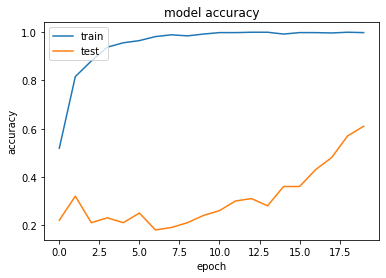

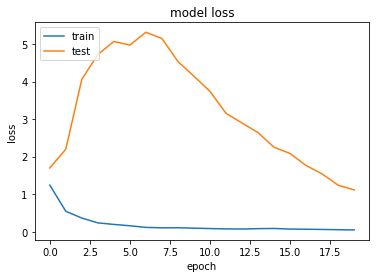

In [28]:
plot_loss_accuracy(history5)

### Conv3D : Model 6

In [16]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 20  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model6 = GestureRecognitionModel(conv_filters=[8,16, 32, 64],kernel_size=(3,3,3), dense_nodes=[64],dropout=0.1,num_images=num_frames,height=height, width=width)

print (model6.summary())

# epochs = 20
# batch size = 20
# num_frames per video = 20
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 120, 120, 8)   656       
                                                                 
 activation_12 (Activation)  (None, 20, 120, 120, 8)   0         
                                                                 
 batch_normalization_10 (Bat  (None, 20, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 60, 60, 8)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 60, 60, 16)    3472      
                                                            

In [19]:
callbacks_list = model_callbacks("model_conv3D_6")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames,augment=True,crop=True)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames,crop=True)

history6 = model6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/20


2023-08-08 17:25:42.311907: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.4425 - categorical_accuracy: 0.4540Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.81268, saving model to model_conv3D_6_2023-08-0817_20_06.848504/model-00001-1.44252-0.45400-1.81268-0.22000.h5
34/34 [==============================] - 111s 3s/step - loss: 1.4425 - categorical_accuracy: 0.4540 - val_loss: 1.8127 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.9674 - categorical_accuracy: 0.6456
Epoch 00002: val_loss did not improve from 1.81268
34/34 [==============================] - 111s 3s/step - loss: 0.9674 - categorical_accuracy: 0.6456 - val_loss: 2.9680 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.7992 - categorical_accuracy: 0.7059
Epoch 00003: val_loss did not improve from 1.81268
34/34 [=============================

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


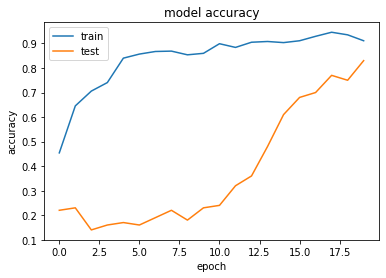

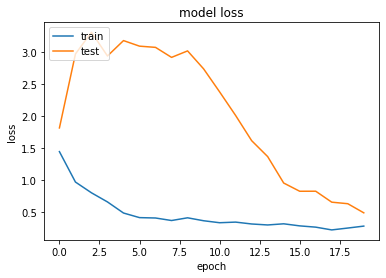

In [20]:
plot_loss_accuracy(history6)

In [22]:
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 20  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model6b = GestureRecognitionModel(conv_filters=[8,16, 32, 64],kernel_size=(3,3,3), dense_nodes=[64],dropout=0.1,num_images=num_frames,height=height, width=width)

print (model6b.summary())

# epochs = 30
# batch size = 20
# num_frames per video = 20
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 20, 120, 120, 8)   656       
                                                                 
 activation_24 (Activation)  (None, 20, 120, 120, 8)   0         
                                                                 
 batch_normalization_20 (Bat  (None, 20, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 10, 60, 60, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 10, 60, 60, 16)    3472      
                                                            

In [23]:
callbacks_list = model_callbacks("model_conv3D_6b")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames,augment=True,crop=True)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames,crop=True)

history6b = model6b.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.3277 - categorical_accuracy: 0.4872Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 2.37871, saving model to model_conv3D_6b_2023-08-0817_20_06.848504/model-00001-1.32767-0.48718-2.37871-0.16000.h5
34/34 [==============================] - 117s 4s/step - loss: 1.3277 - categorical_accuracy: 0.4872 - val_loss: 2.3787 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.0031 - categorical_accuracy: 0.6078
Epoch 00002: val_loss did not improve from 2.37871
34/34 [==============================] - 114s 3s/step - loss: 1.0031 - categorical_accuracy: 0.6078 - val_loss: 4.1334 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.7441 - categorical_accuracy: 0.7270
Epoch 00

### Conv3D : Model 6b

In [12]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 20  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model6b = GestureRecognitionModel(conv_filters=[8,16, 32, 64],kernel_size=(3,3,3), dense_nodes=[64],dropout=0.4,num_images=num_frames,height=height, width=width)

print (model6b.summary())

# epochs = 25
# batch size = 20
# num_frames per video = 20
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 8)   656       
                                                                 
 activation_6 (Activation)   (None, 20, 120, 120, 8)   0         
                                                                 
 batch_normalization_5 (Batc  (None, 20, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 60, 60, 8)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 60, 60, 16)    3472      
                                                            

In [13]:
callbacks_list = model_callbacks("model_conv3D_6b")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames,augment=True)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames)

history6b = model6b.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/25


2023-08-07 16:35:55.472776: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.6289 - categorical_accuracy: 0.3771Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 2.37543, saving model to model_conv3D_6b_2023-08-0716_34_03.014331/model-00001-1.62890-0.37707-2.37543-0.21000.h5
34/34 [==============================] - 126s 4s/step - loss: 1.6289 - categorical_accuracy: 0.3771 - val_loss: 2.3754 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.0430 - categorical_accuracy: 0.5897
Epoch 00002: val_loss did not improve from 2.37543
34/34 [==============================] - 127s 4s/step - loss: 1.0430 - categorical_accuracy: 0.5897 - val_loss: 3.7318 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.8527 - categorical_accuracy: 0.6787
Epoch 00003: val_loss did not improve from 2.37543
34/34 [============================

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


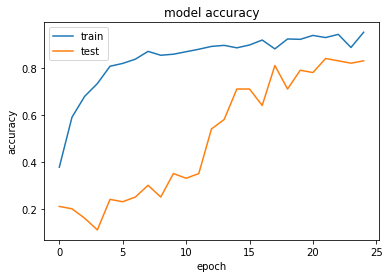

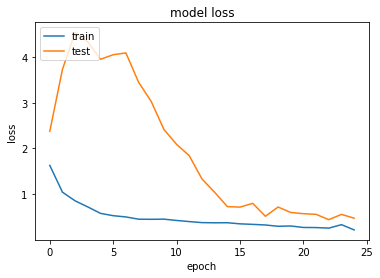

In [14]:
plot_loss_accuracy(history6b)

### Conv3D : Model 7

In [18]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model7 = GestureRecognitionModel(conv_filters=[8,16, 32, 64],kernel_size=(3,3,3), dense_nodes=[64],dropout=0.1,num_images=num_frames,height=height, width=width)

print (model7.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 20
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 20, 120, 120, 8)   656       
                                                                 
 activation_25 (Activation)  (None, 20, 120, 120, 8)   0         
                                                                 
 batch_normalization_21 (Bat  (None, 20, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 10, 60, 60, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 10, 60, 60, 16)    3472      
                                                            

In [19]:
callbacks_list = model_callbacks("model_conv3D_7")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames)

history7 = model7.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.1841 - categorical_accuracy: 0.5294Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 5.22251, saving model to model_conv3D_7_2023-08-0508_59_20.679235/model-00001-1.18411-0.52941-5.22251-0.21000.h5
67/67 [==============================] - 119s 2s/step - loss: 1.1841 - categorical_accuracy: 0.5294 - val_loss: 5.2225 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.6012 - categorical_accuracy: 0.7647
Epoch 00002: val_loss did not improve from 5.22251
67/67 [==============================] - 117s 2s/step - loss: 0.6012 - categorical_accuracy: 0.7647 - val_loss: 5.7396 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.3848 - categorical_accuracy: 0.8718
Epoch 000

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


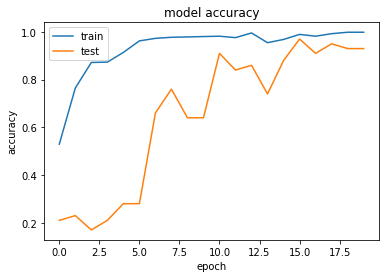

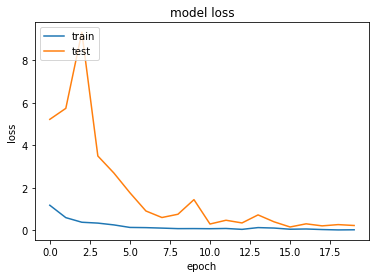

In [25]:
plot_loss_accuracy(history7)

### Conv3D : Model 7b

In [16]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model7b = GestureRecognitionModel(conv_filters=[8,16, 32, 64],kernel_size=(3,3,3), dense_nodes=[64],dropout=0.1,num_images=num_frames,height=height, width=width)

print (model7b.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 20
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 8)   656       
                                                                 
 activation_6 (Activation)   (None, 20, 120, 120, 8)   0         
                                                                 
 batch_normalization_5 (Batc  (None, 20, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 60, 60, 8)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 60, 60, 16)    3472      
                                                            

In [19]:

callbacks_list = model_callbacks("model_conv3D_7b")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames,augment=True, crop=True)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames, crop=True)

history7b = model7b.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 0.9638 - categorical_accuracy: 0.6290Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 2.84974, saving model to model_conv3D_7b_2023-08-0813_38_58.261741/model-00001-0.96384-0.62896-2.84974-0.22000.h5
67/67 [==============================] - 123s 2s/step - loss: 0.9638 - categorical_accuracy: 0.6290 - val_loss: 2.8497 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.7716 - categorical_accuracy: 0.7074
Epoch 00002: val_loss improved from 2.84974 to 2.14733, saving model to model_conv3D_7b_2023-08-0813_38_58.261741/model-00002-0.77159-0.70739-2.14733-0.26000.h5
67/67 [==============================] - 125s 2s/step - loss: 0.7716 - categorical_accuracy: 0.7074 - val_loss: 2.1473 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoc

### Conv3D : Model 8

In [10]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model8 = GestureRecognitionModel(conv_filters=[4, 8, 16, 32],kernel_size=(3,3,3), dense_nodes=[32],dropout=0.1,num_images=num_frames,height=height, width=width)

print (model8.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 20


2023-08-05 16:23:49.625627: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-08-05 16:23:49.637551: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3f:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 120, 120, 4)   328       
                                                                 
 activation (Activation)     (None, 20, 120, 120, 4)   0         
                                                                 
 batch_normalization (BatchN  (None, 20, 120, 120, 4)  16        
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 60, 60, 4)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 60, 60, 8)     872       
                                                                 
 activation_1 (Activation)   (None, 10, 60, 60, 8)     0

In [11]:
callbacks_list = model_callbacks("model_conv3D_8")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames)

history8 = model8.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20


2023-08-05 16:24:07.855382: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.3969 - categorical_accuracy: 0.3952Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 3.29630, saving model to model_conv3D_8_2023-08-0516_21_25.446864/model-00001-1.39688-0.39517-3.29630-0.16000.h5
67/67 [==============================] - 117s 2s/step - loss: 1.3969 - categorical_accuracy: 0.3952 - val_loss: 3.2963 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.9373 - categorical_accuracy: 0.6727
Epoch 00002: val_loss did not improve from 3.29630
67/67 [==============================] - 109s 2s/step - loss: 0.9373 - categorical_accuracy: 0.6727 - val_loss: 6.0807 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.7575 - categorical_accuracy: 0.7436
Epoch 00003: val_loss did not improve from 3.29630
67/67 [=============================

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


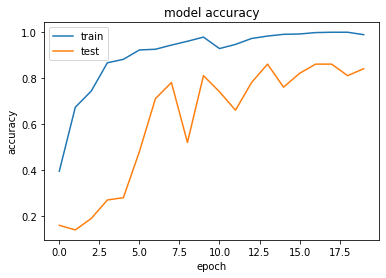

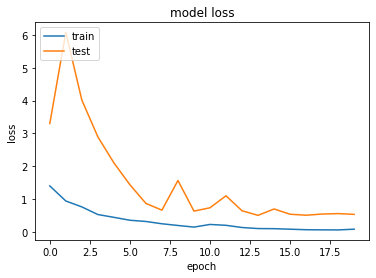

In [14]:
plot_loss_accuracy(history8)

### Conv3D : Model 9

In [15]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model9 = GestureRecognitionModel(conv_filters=[4, 8, 16, 32],kernel_size=(3,3,3), dense_nodes=[32],dropout=0.25,num_images=num_frames,height=height, width=width)

print (model9.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 20
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 4)   328       
                                                                 
 activation_6 (Activation)   (None, 20, 120, 120, 4)   0         
                                                                 
 batch_normalization_5 (Batc  (None, 20, 120, 120, 4)  16        
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 60, 60, 4)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 60, 60, 8)     872       
                                                            

In [16]:
callbacks_list = model_callbacks("model_conv3D_9")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames)

history9 = model9.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.4108 - categorical_accuracy: 0.4344Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 1.92966, saving model to model_conv3D_9_2023-08-0516_21_25.446864/model-00001-1.41081-0.43439-1.92966-0.24000.h5
67/67 [==============================] - 111s 2s/step - loss: 1.4108 - categorical_accuracy: 0.4344 - val_loss: 1.9297 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.0130 - categorical_accuracy: 0.6078
Epoch 00002: val_loss did not improve from 1.92966
67/67 [==============================] - 108s 2s/step - loss: 1.0130 - categorical_accuracy: 0.6078 - val_loss: 2.7051 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.7881 - categorical_accuracy: 0.7104
Epoch 000

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


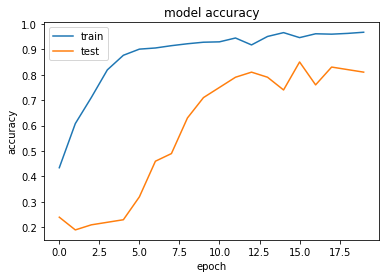

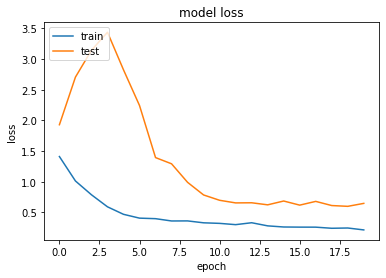

In [17]:
plot_loss_accuracy(history9)

### Conv3D : Model 10

In [21]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model10 = GestureRecognitionModel(conv_filters=[4, 8, 16, 32],kernel_size=(3,3,3), dense_nodes=[32],dropout=0.25,num_images=num_frames,height=height, width=width, regularization_strength =1)

print (model10.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 20
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 20, 120, 120, 4)   328       
                                                                 
 activation_17 (Activation)  (None, 20, 120, 120, 4)   0         
                                                                 
 batch_normalization_15 (Bat  (None, 20, 120, 120, 4)  16        
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 10, 60, 60, 4)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 10, 60, 60, 8)     872       
                                                            

In [22]:
callbacks_list = model_callbacks("model_conv3D_10")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames)

history10 = model10.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 24.8360 - categorical_accuracy: 0.4329Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 19.34727, saving model to model_conv3D_10_2023-08-0516_21_25.446864/model-00001-24.83602-0.43288-19.34727-0.21000.h5
67/67 [==============================] - 109s 2s/step - loss: 24.8360 - categorical_accuracy: 0.4329 - val_loss: 19.3473 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 12.6169 - categorical_accuracy: 0.6561
Epoch 00002: val_loss improved from 19.34727 to 11.08527, saving model to model_conv3D_10_2023-08-0516_21_25.446864/model-00002-12.61686-0.65611-11.08527-0.23000.h5
67/67 [==============================] - 112s 2s/step - loss: 12.6169 - categorical_accuracy: 0.6561 - val_loss: 11.0853 - val_categorical_accuracy: 0.2300 - lr

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


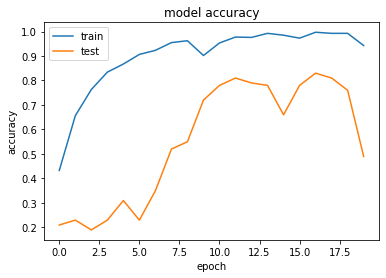

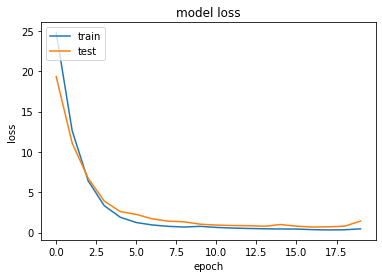

In [23]:
plot_loss_accuracy(history10)

## Type : CNN + RNN

### CNN + RNN using LSTM : Model 11

In [36]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model11 = Conv2D_RNN_GestureRecognitionModel(conv_filters=[8, 16, 32, 64], kernel_size=(3,3),
                                       dense_nodes=[64], dropout=0.25, num_images=num_frames,
                                       height=height, width=width, regularization_strength=0,
                                       num_classes=num_classes)

print (model11.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 20
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_120 (TimeD  (1, 20, 120, 120, 8)     224       
 istributed)                                                     
                                                                 
 time_distributed_121 (TimeD  (1, 20, 120, 120, 8)     0         
 istributed)                                                     
                                                                 
 time_distributed_122 (TimeD  (1, 20, 120, 120, 8)     32        
 istributed)                                                     
                                                                 
 time_distributed_123 (TimeD  (1, 20, 60, 60, 8)       0         
 istributed)                                                     
                                                           

In [37]:
callbacks_list = model_callbacks("model_conv3D_11")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames)

history11 = model11.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20


2023-08-06 10:27:13.745770: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.5117 - categorical_accuracy: 0.4027Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 1.78866, saving model to model_conv3D_11_2023-08-0609_58_18.510379/model-00001-1.51167-0.40271-1.78866-0.22000.h5
67/67 [==============================] - 114s 2s/step - loss: 1.5117 - categorical_accuracy: 0.4027 - val_loss: 1.7887 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.2336 - categorical_accuracy: 0.4992
Epoch 00002: val_loss did not improve from 1.78866
67/67 [==============================] - 108s 2s/step - loss: 1.2336 - categorical_accuracy: 0.4992 - val_loss: 2.1734 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.0321 - categorical_accuracy: 0.6048
Epoch 00003: val_loss did not improve from 1.78866
67/67 [============================

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


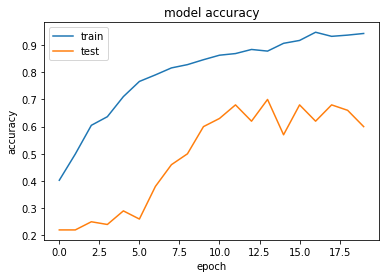

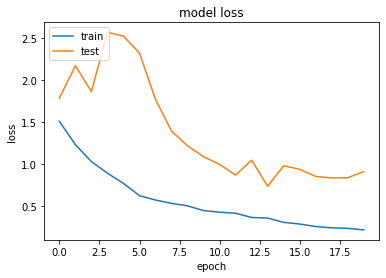

In [40]:
plot_loss_accuracy(history11)

### CNN + RNN using LSTM : Model 12

In [46]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model12 = Conv2D_RNN_GestureRecognitionModel(conv_filters=[8, 16, 32, 64], kernel_size=(3,3),
                                           dense_nodes=[64], dropout=0.25, num_images=num_frames,
                                           height=height, width=width, regularization_strength=0,
                                           num_classes=num_classes)

print (model12.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 20
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_150 (TimeD  (1, 20, 120, 120, 8)     224       
 istributed)                                                     
                                                                 
 time_distributed_151 (TimeD  (1, 20, 120, 120, 8)     0         
 istributed)                                                     
                                                                 
 time_distributed_152 (TimeD  (1, 20, 120, 120, 8)     32        
 istributed)                                                     
                                                                 
 time_distributed_153 (TimeD  (1, 20, 60, 60, 8)       0         
 istributed)                                                     
                                                           

In [47]:
callbacks_list = model_callbacks("model_conv3D_12")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames)

history12 = model12.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.6955 - categorical_accuracy: 0.3379Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 1.69590, saving model to model_conv3D_12_2023-08-0609_58_18.510379/model-00001-1.69552-0.33786-1.69590-0.21000.h5
67/67 [==============================] - 115s 2s/step - loss: 1.6955 - categorical_accuracy: 0.3379 - val_loss: 1.6959 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.3521 - categorical_accuracy: 0.4555
Epoch 00002: val_loss did not improve from 1.69590
67/67 [==============================] - 111s 2s/step - loss: 1.3521 - categorical_accuracy: 0.4555 - val_loss: 1.7083 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.1633 - categorical_accuracy: 0.5219
Epoch 00

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


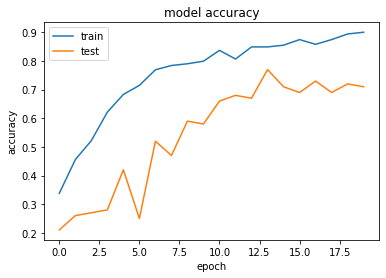

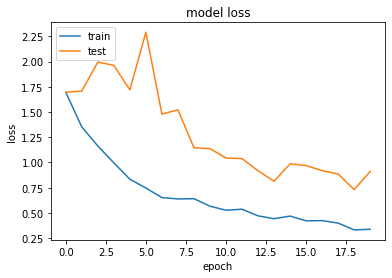

In [48]:
plot_loss_accuracy(history12)

### CNN + RNN using LSTM : Model 13

In [49]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model13 = Conv2D_RNN_GestureRecognitionModel(conv_filters=[8,16, 32], kernel_size=(3,3),
                                           dense_nodes=[32], dropout=0.25, num_images=num_frames,
                                           height=height, width=width, regularization_strength=0,
                                           num_classes=num_classes)

print (model13.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 20
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_167 (TimeD  (1, 20, 120, 120, 8)     224       
 istributed)                                                     
                                                                 
 time_distributed_168 (TimeD  (1, 20, 120, 120, 8)     0         
 istributed)                                                     
                                                                 
 time_distributed_169 (TimeD  (1, 20, 120, 120, 8)     32        
 istributed)                                                     
                                                                 
 time_distributed_170 (TimeD  (1, 20, 60, 60, 8)       0         
 istributed)                                                     
                                                           

In [50]:
callbacks_list = model_callbacks("model_conv3D_13")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames)

history13 = model13.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.6666 - categorical_accuracy: 0.3499Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 1.69452, saving model to model_conv3D_13_2023-08-0609_58_18.510379/model-00001-1.66657-0.34992-1.69452-0.17000.h5
67/67 [==============================] - 118s 2s/step - loss: 1.6666 - categorical_accuracy: 0.3499 - val_loss: 1.6945 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.2029 - categorical_accuracy: 0.5279
Epoch 00002: val_loss did not improve from 1.69452
67/67 [==============================] - 111s 2s/step - loss: 1.2029 - categorical_accuracy: 0.5279 - val_loss: 2.2397 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.0635 - categorical_accuracy: 0.5882
Epoch 00

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


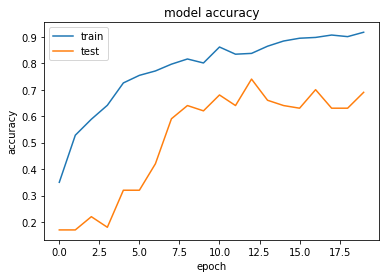

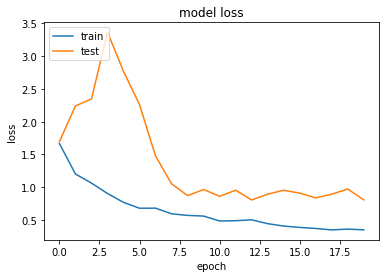

In [51]:
plot_loss_accuracy(history13)

### CNN + RNN using LSTM : Model 14

In [53]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model14 = Conv2D_RNN_GestureRecognitionModel(conv_filters=[8,16, 32], kernel_size=(3,3),
                                           dense_nodes=[32], dropout=0.25, num_images=num_frames,
                                           height=height, width=width, regularization_strength=0,
                                           num_classes=num_classes,pooling=False)

print (model14.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 20
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_180 (TimeD  (1, 20, 120, 120, 8)     224       
 istributed)                                                     
                                                                 
 time_distributed_181 (TimeD  (1, 20, 120, 120, 8)     0         
 istributed)                                                     
                                                                 
 time_distributed_182 (TimeD  (1, 20, 120, 120, 8)     32        
 istributed)                                                     
                                                                 
 time_distributed_183 (TimeD  (1, 20, 120, 120, 16)    1168      
 istributed)                                                     
                                                           

In [54]:
callbacks_list = model_callbacks("model_conv3D_14")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames)

history14 = model14.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/25


2023-08-06 13:29:28.544433: W tensorflow/core/common_runtime/bfc_allocator.cc:463] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.58MiB (rounded to 18432000)requested by op sequential_14/lstm_12/while/body/_1/sequential_14/lstm_12/while/lstm_cell_12/ones_like
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-08-06 13:29:28.544585: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2023-08-06 13:29:28.544612: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 727, Chunks in use: 727. 181.8KiB allocated for chunks. 181.8KiB in use in bin. 30.7KiB client-requested in use in bin.
2023-08-06 13:29:28.544676: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 15, Chunks in use: 15. 8.8KiB allocated for chunks. 8.8KiB in u

ResourceExhaustedError:  OOM when allocating tensor with shape[10,460800] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_14/lstm_12/while/lstm_cell_12/ones_like
 (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/recurrent.py:1184)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_59434]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_14/lstm_12/while/lstm_cell_12/ones_like:
In[0] sequential_14/lstm_12/while/lstm_cell_12/ones_like/Shape:	
In[1] sequential_14/lstm_12/while/lstm_cell_12/ones_like/Const:

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 359, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_303/1962341238.py", line 9, in <module>
>>>     history14 = model14.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/sequential.py", line 373, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/layers/recurrent.py", line 679, in __call__
>>>     return super(RNN, self).__call__(inputs, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/layers/recurrent_v2.py", line 1158, in call
>>>     last_output, outputs, states = backend.rnn(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/backend.py", line 4654, in rnn
>>>     final_outputs = tf.compat.v1.while_loop(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/backend.py", line 4640, in _step
>>>     output, new_states = step_function(current_input,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/layers/recurrent_v2.py", line 1156, in step
>>>     return self.cell(inputs, states, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/layers/recurrent.py", line 2449, in call
>>>     dp_mask = self.get_dropout_mask_for_cell(inputs, training, count=4)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/layers/recurrent.py", line 1215, in get_dropout_mask_for_cell
>>>     return self._dropout_mask_cache.setdefault(kwargs=init_kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/backend.py", line 6772, in setdefault
>>>     default = self.default_factory(**kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/layers/recurrent.py", line 1184, in _create_dropout_mask
>>>     tf.ones_like(inputs),
>>> 

Function call stack:
train_function -> sequential_14_lstm_12_while_body_57613_rewritten


### CNN + RNN using LSTM : Model 15

In [12]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model15 = Conv2D_RNN_GestureRecognitionModel(conv_filters=[8,16, 32], kernel_size=(3,3),
                                           dense_nodes=[32], dropout=0.25, num_images=num_frames,
                                           height=height, width=width, regularization_strength=0,
                                           num_classes=num_classes,pooling=False)

print (model15.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 20


2023-08-06 13:51:15.203236: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-08-06 13:51:15.203308: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:40:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (1, 20, 120, 120, 8)     224       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (1, 20, 120, 120, 8)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (1, 20, 120, 120, 8)     32        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (1, 20, 120, 120, 16)    1168      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (1, 20, 120, 120, 16)    0

In [ ]:
#Model parameters is too much. will not check this further.

### CNN + RNN using LSTM : Model 16

In [14]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model16 = Conv2D_RNN_GestureRecognitionModel(conv_filters=[4,8,16], kernel_size=(3,3),
                                           dense_nodes=[16], dropout=0.25, num_images=num_frames,
                                           height=height, width=width, regularization_strength=0,
                                           num_classes=num_classes)

print (model16.summary())



# epochs = 25
# batch size = 10
# num_frames per video = 20
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeDi  (1, 20, 120, 120, 4)     112       
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (1, 20, 120, 120, 4)     0         
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (1, 20, 120, 120, 4)     16        
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (1, 20, 60, 60, 4)       0         
 stributed)                                                      
                                                            

In [16]:
callbacks_list = model_callbacks("model_conv3D_16")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames, augment=True)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames)##gc

history16 = model16.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 1.6152 - categorical_accuracy: 0.2956Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 1.80563, saving model to model_conv3D_16_2023-08-0613_51_03.023279/model-00001-1.61520-0.29563-1.80563-0.23000.h5
67/67 [==============================] - 143s 2s/step - loss: 1.6152 - categorical_accuracy: 0.2956 - val_loss: 1.8056 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.3987 - categorical_accuracy: 0.4072
Epoch 00002: val_loss did not improve from 1.80563
67/67 [==============================] - 136s 2s/step - loss: 1.3987 - categorical_accuracy: 0.4072 - val_loss: 2.3010 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 1.3863 - categorical_accuracy: 0.4118
Epoch 00

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


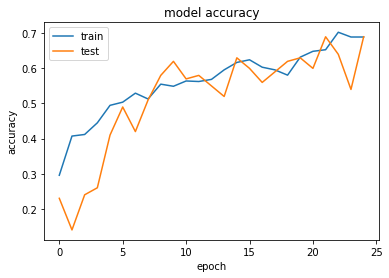

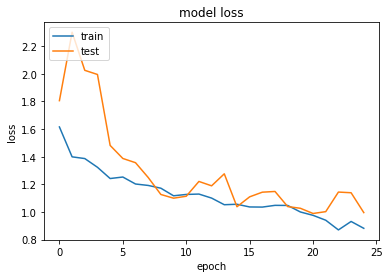

In [17]:
plot_loss_accuracy(history16)

### CNN + RNN using LSTM : Model 17

In [19]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model17 = Conv2D_RNN_GestureRecognitionModel(conv_filters=[8,16,32,64], kernel_size=(3,3),
                                           dense_nodes=[64], dropout=0.1, num_images=num_frames,
                                           height=height, width=width, regularization_strength=0,
                                           num_classes=num_classes)

print (model17.summary())



# epochs = 20
# batch size = 10
# num_frames per video = 20
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_40 (TimeDi  (1, 20, 120, 120, 8)     224       
 stributed)                                                      
                                                                 
 time_distributed_41 (TimeDi  (1, 20, 120, 120, 8)     0         
 stributed)                                                      
                                                                 
 time_distributed_42 (TimeDi  (1, 20, 120, 120, 8)     32        
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (1, 20, 60, 60, 8)       0         
 stributed)                                                      
                                                            

In [20]:
callbacks_list = model_callbacks("model_conv3D_17")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames, augment=True)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames)##gc

history17 = model17.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.6414 - categorical_accuracy: 0.3363Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 1.64658, saving model to model_conv3D_17_2023-08-0613_51_03.023279/model-00001-1.64136-0.33635-1.64658-0.20000.h5
67/67 [==============================] - 142s 2s/step - loss: 1.6414 - categorical_accuracy: 0.3363 - val_loss: 1.6466 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.3195 - categorical_accuracy: 0.4932
Epoch 00002: val_loss did not improve from 1.64658
67/67 [==============================] - 132s 2s/step - loss: 1.3195 - categorical_accuracy: 0.4932 - val_loss: 1.6787 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.0977 - categorical_accuracy: 0.5445
Epoch 00

### CNN + RNN using LSTM : Model 17b

In [21]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model17b = Conv2D_RNN_GestureRecognitionModel(conv_filters=[8,16,32,64], kernel_size=(3,3),
                                           dense_nodes=[64], dropout=0.1, num_images=num_frames,
                                           height=height, width=width, regularization_strength=0,
                                           num_classes=num_classes)

print (model17b.summary())



# epochs = 20
# batch size = 10
# num_frames per video = 20
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_57 (TimeDi  (1, 20, 120, 120, 8)     224       
 stributed)                                                      
                                                                 
 time_distributed_58 (TimeDi  (1, 20, 120, 120, 8)     0         
 stributed)                                                      
                                                                 
 time_distributed_59 (TimeDi  (1, 20, 120, 120, 8)     32        
 stributed)                                                      
                                                                 
 time_distributed_60 (TimeDi  (1, 20, 60, 60, 8)       0         
 stributed)                                                      
                                                            

In [22]:
callbacks_list = model_callbacks("model_conv3D_17b")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames, augment=True)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames)

history17b = model17b.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.4846 - categorical_accuracy: 0.3967Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 1.64759, saving model to model_conv3D_17b_2023-08-0613_51_03.023279/model-00001-1.48457-0.39668-1.64759-0.17000.h5
67/67 [==============================] - 146s 2s/step - loss: 1.4846 - categorical_accuracy: 0.3967 - val_loss: 1.6476 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.1038 - categorical_accuracy: 0.5732
Epoch 00002: val_loss did not improve from 1.64759
67/67 [==============================] - 161s 2s/step - loss: 1.1038 - categorical_accuracy: 0.5732 - val_loss: 1.9538 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.9533 - categorical_accuracy: 0.6335
Epoch 0

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


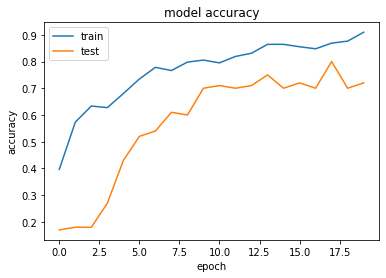

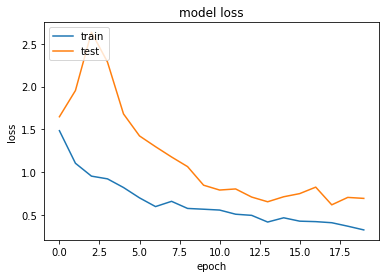

In [23]:
plot_loss_accuracy(history17b)

### CNN + RNN using LSTM : Model 18

In [11]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model18 = Conv2D_RNN_GestureRecognitionModel(conv_filters=[8, 16, 32, 64], kernel_size=(3,3),
                                           dense_nodes=[64, 64], dropout=0.4, num_images=num_frames,
                                           height=height, width=width, regularization_strength=0,
                                           num_classes=num_classes)

print (model18.summary())



# epochs = 20
# batch size = 10
# num_frames per video = 30


2023-08-06 17:59:12.064700: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-08-06 17:59:12.064759: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (1, 30, 120, 120, 8)     224       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (1, 30, 120, 120, 8)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (1, 30, 120, 120, 8)     32        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (1, 30, 60, 60, 8)       0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (1, 30, 60, 60, 16)      1

In [ ]:
callbacks_list = model_callbacks("model_conv3D_18")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames, augment=True)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames)

history18 = model18.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


### CNN + RNN using LSTM : Model 19

In [11]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model19 = Conv2D_RNN_GestureRecognitionModel(conv_filters=[8, 16, 32, 64], kernel_size=(3,3),
                                           dense_nodes=[64, 64], dropout=0.4, num_images=num_frames,
                                           height=height, width=width, regularization_strength=0,
                                           num_classes=num_classes)

print (model19.summary())



# epochs = 20
# batch size = 10
# num_frames per video = 20


2023-08-07 09:46:39.487774: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-08-07 09:46:39.487851: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 40808 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:88:00.0, compute capability: 8.6


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (1, 20, 120, 120, 8)     224       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (1, 20, 120, 120, 8)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (1, 20, 120, 120, 8)     32        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (1, 20, 60, 60, 8)       0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (1, 20, 60, 60, 16)      1

In [12]:
callbacks_list = model_callbacks("model_conv3D_19")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames, augment=True)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames)

history19 = model19.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20


2023-08-07 09:47:16.399912: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302
2023-08-07 09:47:20.899494: I tensorflow/stream_executor/cuda/cuda_blas.cc:1792] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


67/67 [==============================] - ETA: 0s - loss: 2.4746 - categorical_accuracy: 0.2157Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 1.60946, saving model to model_conv3D_19_2023-08-0709_46_27.345927/model-00001-2.47456-0.21569-1.60946-0.21000.h5
67/67 [==============================] - 162s 2s/step - loss: 2.4746 - categorical_accuracy: 0.2157 - val_loss: 1.6095 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.9648 - categorical_accuracy: 0.3092
Epoch 00002: val_loss did not improve from 1.60946
67/67 [==============================] - 147s 2s/step - loss: 1.9648 - categorical_accuracy: 0.3092 - val_loss: 2.2907 - val_categorical_accuracy: 0.1300 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.8185 - categorical_accuracy: 0.3379
Epoch 00003: val_loss did not improve from 1.60946
67/67 [============================

### CNN + RNN using LSTM : Model 19

In [26]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model19 = Conv2D_RNN_GestureRecognitionModel(conv_filters=[4, 8, 16, 32], kernel_size=(3,3),
                                           dense_nodes=[32], dropout=0.4, num_images=num_frames,
                                           height=height, width=width, regularization_strength=0.01,
                                           num_classes=num_classes, lstm_unit=32)

print (model19.summary())



# epochs = 20
# batch size = 10
# num_frames per video = 20
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_117 (TimeD  (1, 20, 120, 120, 4)     112       
 istributed)                                                     
                                                                 
 time_distributed_118 (TimeD  (1, 20, 120, 120, 4)     0         
 istributed)                                                     
                                                                 
 time_distributed_119 (TimeD  (1, 20, 120, 120, 4)     16        
 istributed)                                                     
                                                                 
 time_distributed_120 (TimeD  (1, 20, 60, 60, 4)       0         
 istributed)                                                     
                                                            

In [31]:

callbacks_list = model_callbacks("model_conv3D_19")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames)

history19 = model19.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.7682 - categorical_accuracy: 0.3710Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 1.91700, saving model to model_conv3D_19_2023-08-0709_46_27.345927/model-00001-1.76824-0.37104-1.91700-0.26000.h5
67/67 [==============================] - 110s 2s/step - loss: 1.7682 - categorical_accuracy: 0.3710 - val_loss: 1.9170 - val_categorical_accuracy: 0.2600 - lr: 1.0000e-04
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.7224 - categorical_accuracy: 0.3937
Epoch 00002: val_loss did not improve from 1.91700
67/67 [==============================] - 109s 2s/step - loss: 1.7224 - categorical_accuracy: 0.3937 - val_loss: 1.9275 - val_categorical_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.6547 - categorical_accuracy: 0.3997


### CNN + RNN using LSTM : Model 20

In [11]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model20 = Conv2D_RNN_GestureRecognitionModel(conv_filters=[4, 8, 16, 32], kernel_size=(3,3),
                                           dense_nodes=[32], dropout=0.4, num_images=num_frames,
                                           height=height, width=width, regularization_strength=0.01,
                                           num_classes=num_classes, lstm_unit=32)

print (model20.summary())



# epochs = 20
# batch size = 10
# num_frames per video = 20


2023-08-07 13:50:27.135086: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-08-07 13:50:27.135148: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (1, 20, 120, 120, 4)     112       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (1, 20, 120, 120, 4)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (1, 20, 120, 120, 4)     16        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (1, 20, 60, 60, 4)       0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (1, 20, 60, 60, 8)       2

In [12]:

callbacks_list = model_callbacks("model_conv3D_20")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames, augment=True)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames)

history20 = model20.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20


2023-08-07 13:50:44.166835: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 2.3027 - categorical_accuracy: 0.2338Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 1.93003, saving model to model_conv3D_20_2023-08-0713_50_11.730664/model-00001-2.30267-0.23379-1.93003-0.19000.h5
67/67 [==============================] - 133s 2s/step - loss: 2.3027 - categorical_accuracy: 0.2338 - val_loss: 1.9300 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.7984 - categorical_accuracy: 0.3273
Epoch 00002: val_loss did not improve from 1.93003
67/67 [==============================] - 126s 2s/step - loss: 1.7984 - categorical_accuracy: 0.3273 - val_loss: 2.0451 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.6831 - categorical_accuracy: 0.4072
Epoch 00003: val_loss did not improve from 1.93003
67/67 [============================

### CNN + RNN using LSTM : Model 21

In [18]:
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model21 = Conv2D_RNN_GestureRecognitionModel(conv_filters=[4, 8, 16, 32], kernel_size=(3,3),
                                           dense_nodes=[32], dropout=0.4, num_images=num_frames,
                                           height=height, width=width, regularization_strength=0.01,
                                           num_classes=num_classes, lstm_unit=32)

print (model21.summary())



# epochs = 30
# batch size = 10
# num_frames per video = 30
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_51 (TimeDi  (1, 30, 120, 120, 4)     112       
 stributed)                                                      
                                                                 
 time_distributed_52 (TimeDi  (1, 30, 120, 120, 4)     0         
 stributed)                                                      
                                                                 
 time_distributed_53 (TimeDi  (1, 30, 120, 120, 4)     16        
 stributed)                                                      
                                                                 
 time_distributed_54 (TimeDi  (1, 30, 60, 60, 4)       0         
 stributed)                                                      
                                                            

In [19]:

callbacks_list = model_callbacks("model_conv3D_21")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames, augment=True)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames)

history21 = model21.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 2.3266 - categorical_accuracy: 0.2609Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 1.99101, saving model to model_conv3D_21_2023-08-0716_34_03.014331/model-00001-2.32656-0.26094-1.99101-0.22000.h5
67/67 [==============================] - 197s 3s/step - loss: 2.3266 - categorical_accuracy: 0.2609 - val_loss: 1.9910 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.8484 - categorical_accuracy: 0.3288
Epoch 00002: val_loss did not improve from 1.99101
67/67 [==============================] - 191s 3s/step - loss: 1.8484 - categorical_accuracy: 0.3288 - val_loss: 2.0011 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 1.6444 - categorical_accuracy: 0.4103
Epoch 00

#SHORTLISTED MODELS

###Model 1 - [Min parameters]

In [14]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

finalmodel1 = GestureRecognitionModel(conv_filters=[4, 8, 16, 32],kernel_size=(3,3,3), dense_nodes=[32],dropout=0.1,num_images=num_frames,height=height, width=width)

print (finalmodel1.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 20
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 4)   328       
                                                                 
 activation_6 (Activation)   (None, 20, 120, 120, 4)   0         
                                                                 
 batch_normalization_5 (Batc  (None, 20, 120, 120, 4)  16        
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 60, 60, 4)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 60, 60, 8)     872       
                                                            

In [15]:
callbacks_list = model_callbacks("model_conv3D_finalmodel1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames,augment=True,crop=True)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames,crop=True)

finalhistory1 = finalmodel1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20


2023-08-09 06:02:37.490017: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.4705 - categorical_accuracy: 0.3922Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 2.10118, saving model to model_conv3D_finalmodel1_2023-08-0906_01_31.158141/model-00001-1.47055-0.39216-2.10118-0.17000.h5
67/67 [==============================] - 104s 2s/step - loss: 1.4705 - categorical_accuracy: 0.3922 - val_loss: 2.1012 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.1931 - categorical_accuracy: 0.5279
Epoch 00002: val_loss did not improve from 2.10118
67/67 [==============================] - 98s 1s/step - loss: 1.1931 - categorical_accuracy: 0.5279 - val_loss: 3.6315 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.1068 - categorical_accuracy: 0.5701
Epoch 00003: val_loss did not improve from 2.10118
67/67 [====================

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


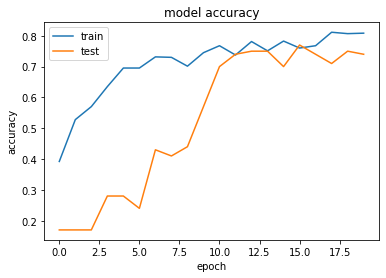

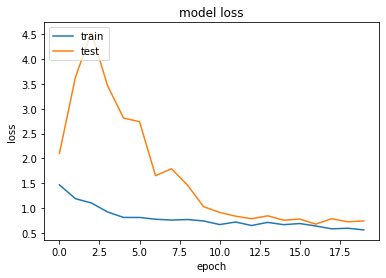

In [20]:
plot_loss_accuracy(finalhistory1)

In [17]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

finalmodel1a = GestureRecognitionModel(conv_filters=[4, 8, 16, 32],kernel_size=(3,3,3), dense_nodes=[32],dropout=0.1,num_images=num_frames,height=height, width=width, regularization_strength=0.01)

print (finalmodel1a.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 20
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 20, 120, 120, 4)   328       
                                                                 
 activation_19 (Activation)  (None, 20, 120, 120, 4)   0         
                                                                 
 batch_normalization_16 (Bat  (None, 20, 120, 120, 4)  16        
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 10, 60, 60, 4)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 10, 60, 60, 8)     872       
                                                            

In [18]:
callbacks_list = model_callbacks("model_conv3D_finalmodel1a")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames,augment=True,crop=True)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames,crop=True)

finalhistory1a = finalmodel1a.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 1.8345 - categorical_accuracy: 0.3861Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 3.45643, saving model to model_conv3D_finalmodel1a_2023-08-0906_01_31.158141/model-00001-1.83452-0.38612-3.45643-0.16000.h5
67/67 [==============================] - 102s 2s/step - loss: 1.8345 - categorical_accuracy: 0.3861 - val_loss: 3.4564 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.4460 - categorical_accuracy: 0.5158
Epoch 00002: val_loss did not improve from 3.45643
67/67 [==============================] - 98s 1s/step - loss: 1.4460 - categorical_accuracy: 0.5158 - val_loss: 5.3899 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 1.3330 - categorical_accuracy: 0.5777

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


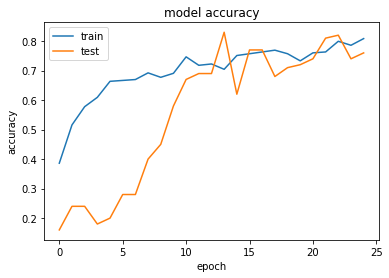

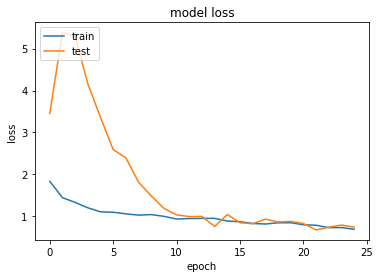

In [19]:
plot_loss_accuracy(finalhistory1a)

### Model 2 [More parameters]

In [13]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

finalmodel2 = GestureRecognitionModel(conv_filters=[8, 16, 32, 64],kernel_size=(3,3,3), dense_nodes=[64],dropout=0.1,num_images=num_frames,height=height, width=width, regularization_strength=0.01)

print (finalmodel2.summary())


# epochs = 20
# batch size = 10
# num_frames per video = 20
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 8)   656       
                                                                 
 activation_6 (Activation)   (None, 20, 120, 120, 8)   0         
                                                                 
 batch_normalization_5 (Batc  (None, 20, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 60, 60, 8)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 60, 60, 16)    3472      
                                                            

In [14]:

callbacks_list = model_callbacks("model_conv3D_finalmodel2")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames,augment=True,crop=True)

val_generator   = generator(val_path, val_doc, batch_size, num_images=num_frames,crop=True)

finalhistory2 = finalmodel2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20


2023-08-09 10:18:40.847592: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.9461 - categorical_accuracy: 0.4781Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 3.21653, saving model to model_conv3D_finalmodel2_2023-08-0910_15_17.204449/model-00001-1.94613-0.47813-3.21653-0.16000.h5
67/67 [==============================] - 105s 2s/step - loss: 1.9461 - categorical_accuracy: 0.4781 - val_loss: 3.2165 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.5934 - categorical_accuracy: 0.5686
Epoch 00002: val_loss did not improve from 3.21653
67/67 [==============================] - 104s 2s/step - loss: 1.5934 - categorical_accuracy: 0.5686 - val_loss: 5.6166 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.3747 - categorical_accuracy: 0.6456
Epoch 00003: val_loss did not improve from 3.21653
67/67 [===================

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


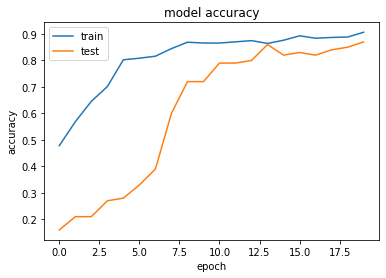

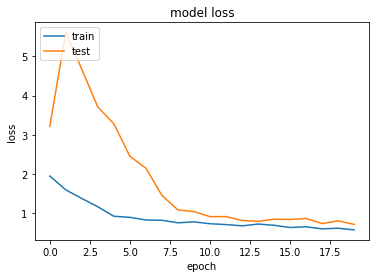

In [15]:
plot_loss_accuracy(finalhistory2)

#FINAL MODEL

In [24]:
# Load the Keras model from the .h5 file
model_path = 'model_conv3D_finalmodel2_2023-08-0910_15_17.204449/model-00020-0.57196-0.90649-0.71353-0.87000.h5'
model = load_model(model_path)

# Print model summary
print("Model Summary:")
model.summary()

# Get model input shape
input_shape = model.input_shape
print("\nModel Input Shape:", input_shape)

# Get model output shape
output_shape = model.output_shape
print("Model Output Shape:", output_shape)

# Get model number of parameters
num_params = model.count_params()
print("Number of Model Parameters:", num_params)

# Get model architecture configuration
model_config = model.get_config()

# Print some information about layers
print("\nModel Layers:")
for layer_info in model_config["layers"]:
    layer_name = layer_info["config"]["name"]
    layer_type = layer_info["class_name"]
    print(f"Layer Name: {layer_name}, Type: {layer_type}")


Model Summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 8)   656       
                                                                 
 activation_6 (Activation)   (None, 20, 120, 120, 8)   0         
                                                                 
 batch_normalization_5 (Batc  (None, 20, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 60, 60, 8)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 60, 60, 16)    3472      
                                                                 
 activation_7 (Activation)   (None, 10,